In [1]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd

from jitr.utils import mass

In [2]:
def neutron_fermi_energy_KD(A, Z):
    return -11.2814 + 0.02646 * A


def proton_fermi_energy_KD(A, Z):
    return -8.4075 + 0.01378 * A

## Compare models to KD

In [3]:
A, Z = (154, 56)

In [4]:
for m in mass.__MASS_MODELS__:
    Ef = mass.neutron_fermi_energy(A, Z, model=m)
    print(f"{m:7}: {Ef[0]:1.4f} +/- {Ef[1]}")

BMA    : -3.6700 +/- 2.928163874630591
ws4rbf : -3.4174 +/- nan
UNEDF2 : -3.5264 +/- nan
dz31   : -3.4939 +/- nan
UNEDF1 : -3.4964 +/- nan
HFB24  : -3.7864 +/- nan
SVMIN  : -3.6514 +/- nan
SKM    : -4.1414 +/- nan
UNEDF0 : -3.6114 +/- nan
hfb31  : -3.6514 +/- nan
D1M    : -3.6014 +/- nan
SLY4   : -3.4264 +/- nan
SKP    : -3.6264 +/- nan
ame2020: nan +/- nan
BCPM   : -3.6764 +/- nan
FRDM2012: -3.5514 +/- nan


In [5]:
neutron_fermi_energy_KD(A, Z)

-7.20656

In [6]:
for m in mass.__MASS_MODELS__:
    Ef = mass.proton_fermi_energy(A, Z, model=m)
    print(f"{m:7}: {Ef[0]:1.4f} +/- {Ef[1]}")

BMA    : -13.1027 +/- 2.8786616888136276
ws4rbf : -13.8941 +/- nan
UNEDF2 : -13.6486 +/- nan
dz31   : -13.5521 +/- nan
UNEDF1 : -13.7586 +/- nan
HFB24  : -13.2636 +/- nan
SVMIN  : -13.4186 +/- nan
SKM    : -12.5986 +/- nan
UNEDF0 : -13.3486 +/- nan
hfb31  : -12.6936 +/- nan
D1M    : -13.6836 +/- nan
SLY4   : -13.8936 +/- nan
SKP    : -13.1386 +/- nan
ame2020: nan +/- nan
BCPM   : -13.2686 +/- nan
FRDM2012: -13.5936 +/- nan


In [7]:
proton_fermi_energy_KD(A, Z)

-6.28538

## Transmission coefficients
Let's use `jitr` to calculate UQ'ed transmission coefficients using KDUQ Fermi energies and those from a variety of mass models

In [8]:
from tqdm import tqdm

import jitr

In [9]:
A, Z = (154, 56)
neutron = (1, 0)
target = (A, Z)

In [10]:
# we have 416 samples from the KDUQ posterior
num_samples_kduq = 415
param_files = [
    Path(jitr.data_dir / f"KDUQFederal/{i}/parameters.json").absolute()
    for i in range(0, num_samples_kduq)
]

# load each one
kduq_omp_samples = [
    jitr.reactions.kduq.KDGlobal(neutron, Path(param_file))
    for param_file in param_files
]

In [14]:
# com_energy_grid = np.logspace(-1, 1.3, 100)
com_energy_grid = np.logspace(-2, 1, 100)
core_solvers = jitr.rmatrix.Solver(30)
range_fm = jitr.utils.interaction_range(A)

In [17]:
def set_up_grid(core, com_energy_grid, mass_model):
    solvers = []
    lab_energy_grid = np.zeros_like(com_energy_grid)
    mn = jitr.utils.constants.MASS_N
    mcore = jitr.utils.mass.mass(*target, model=mass_model)[0]
    for i, Ecm in enumerate(tqdm(com_energy_grid)):
        Elab, kinematics = jitr.utils.kinematics.classical_kinematics_cm(mcore, mn, Ecm)
        dimensionless_channel_rad = jitr.utils.suggested_dimensionless_channel_radius(
            range_fm, kinematics.k
        )
        N = jitr.utils.suggested_basis_size(dimensionless_channel_rad)
        assert N < core_solver.kernel.quadrature.nbasis
        lab_energy_grid[i] = Elab
        sys = jitr.reactions.ProjectileTargetSystem(
            channel_radius=dimensionless_channel_rad,
            lmax=10,
            mass_target=mcore,
            mass_projectile=mn,
            Ztarget=core[1],
            Zproj=0,
            coupling=jitr.reactions.system.spin_half_orbit_coupling,
        )

        solvers.append(
            jitr.xs.elastic.IntegralWorkspace(
                projectile=neutron,
                target=core,
                sys=sys,
                kinematics=kinematics,
                solver=core_solver,
                smatrix_abs_tol=0,
            )
        )
    return solvers, lab_energy_grid

In [18]:
solvers, lab_energy_grid = set_up_grid(target, com_energy_grid, mass_model="BMA")

100%|█████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.54it/s]


## Run UQ

In [19]:
N = 300  # number of samples to draw from each posterior
draws_kduq = np.random.choice(len(kduq_omp_samples), size=N)

### KDUQ

In [20]:
tcoeff_kduq = np.zeros((com_energy_grid.size, N, 2, 10))
for j, sample in enumerate(tqdm(draws_kduq)):
    omp = kduq_omp_samples[sample]

    for i, Ecm in enumerate(com_energy_grid):
        coulomb_params, scalar_params, spin_orbit_params = omp.get_params(
            *target, solvers[i].mu, lab_energy_grid[i], solvers[i].k
        )

        tplus, tminus = solvers[i].transmission_coefficients(
            jitr.reactions.KD_central,
            jitr.reactions.KD_spin_orbit,
            scalar_params,
            spin_orbit_params,
        )
        tcoeff_kduq[i, j, 0, :] = tplus
        tcoeff_kduq[i, j, 1, :] = tminus

 73%|████████████████████████████████████████████▎                | 218/300 [04:48<01:43,  1.26s/it]/home/beyerk/Projects/jitr/src/jitr/reactions/kduq.py:277: RuntimeWarning: overflow encountered in exp
  d2 = self.d2_0 + self.d2_A / (1 + np.exp((A - self.d2_A3) / self.d2_A2))
100%|█████████████████████████████████████████████████████████████| 300/300 [06:37<00:00,  1.32s/it]


### KDUQ wth BMA Fermi energies

In [21]:
# set Fermi energy to BMA
Ef = mass.neutron_fermi_energy(A, Z, model="BMA")

In [22]:
tcoeff_kduq_bma = np.zeros((com_energy_grid.size, N, 2, 10))
for j, sample in enumerate(tqdm(draws_kduq)):
    omp = kduq_omp_samples[sample]

    # reset Ef
    omp.Ef_A = 0
    omp.Ef_0 = np.random.normal(loc=Ef[0], scale=Ef[1])  # sample from BMA

    for i, Ecm in enumerate(com_energy_grid):

        coulomb_params, scalar_params, spin_orbit_params = omp.get_params(
            *target, solvers[i].mu, lab_energy_grid[i], solvers[i].k
        )

        tplus, tminus = solvers[i].transmission_coefficients(
            jitr.reactions.KD_central,
            jitr.reactions.KD_spin_orbit,
            scalar_params,
            spin_orbit_params,
        )
        tcoeff_kduq_bma[i, j, 0, :] = tplus
        tcoeff_kduq_bma[i, j, 1, :] = tminus

100%|█████████████████████████████████████████████████████████████| 300/300 [06:09<00:00,  1.23s/it]


## Extract confidence intervals

In [23]:
def get_confidence_intervals(tcoeffs):
    ci = []
    for l in range(10):
        ci.append([])
        ci[l].append(
            (
                np.percentile(tcoeffs[:, :, 0, l], 16, axis=1),
                np.percentile(tcoeffs[:, :, 0, l], 84, axis=1),
            )
        )
        if l > 0:
            ci[l].append(
                (
                    np.percentile(tcoeffs[:, :, 1, l], 16, axis=1),
                    np.percentile(tcoeffs[:, :, 1, l], 84, axis=1),
                )
            )
    return ci

In [24]:
kduq_ci = get_confidence_intervals(tcoeff_kduq)
kduq_bma_ci = get_confidence_intervals(tcoeff_kduq_bma)

## Plotting

In [25]:
kduq_color = "tab:blue"
bma_color = "tab:orange"

In [26]:
from matplotlib import pyplot as plt
from matplotlib import rcParams

plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
plt.rc("text", usetex=True)
rcParams["text.latex.preamble"] = (
    r"\usepackage{amssymb} \usepackage{amsmath} \usepackage{braket}"
)

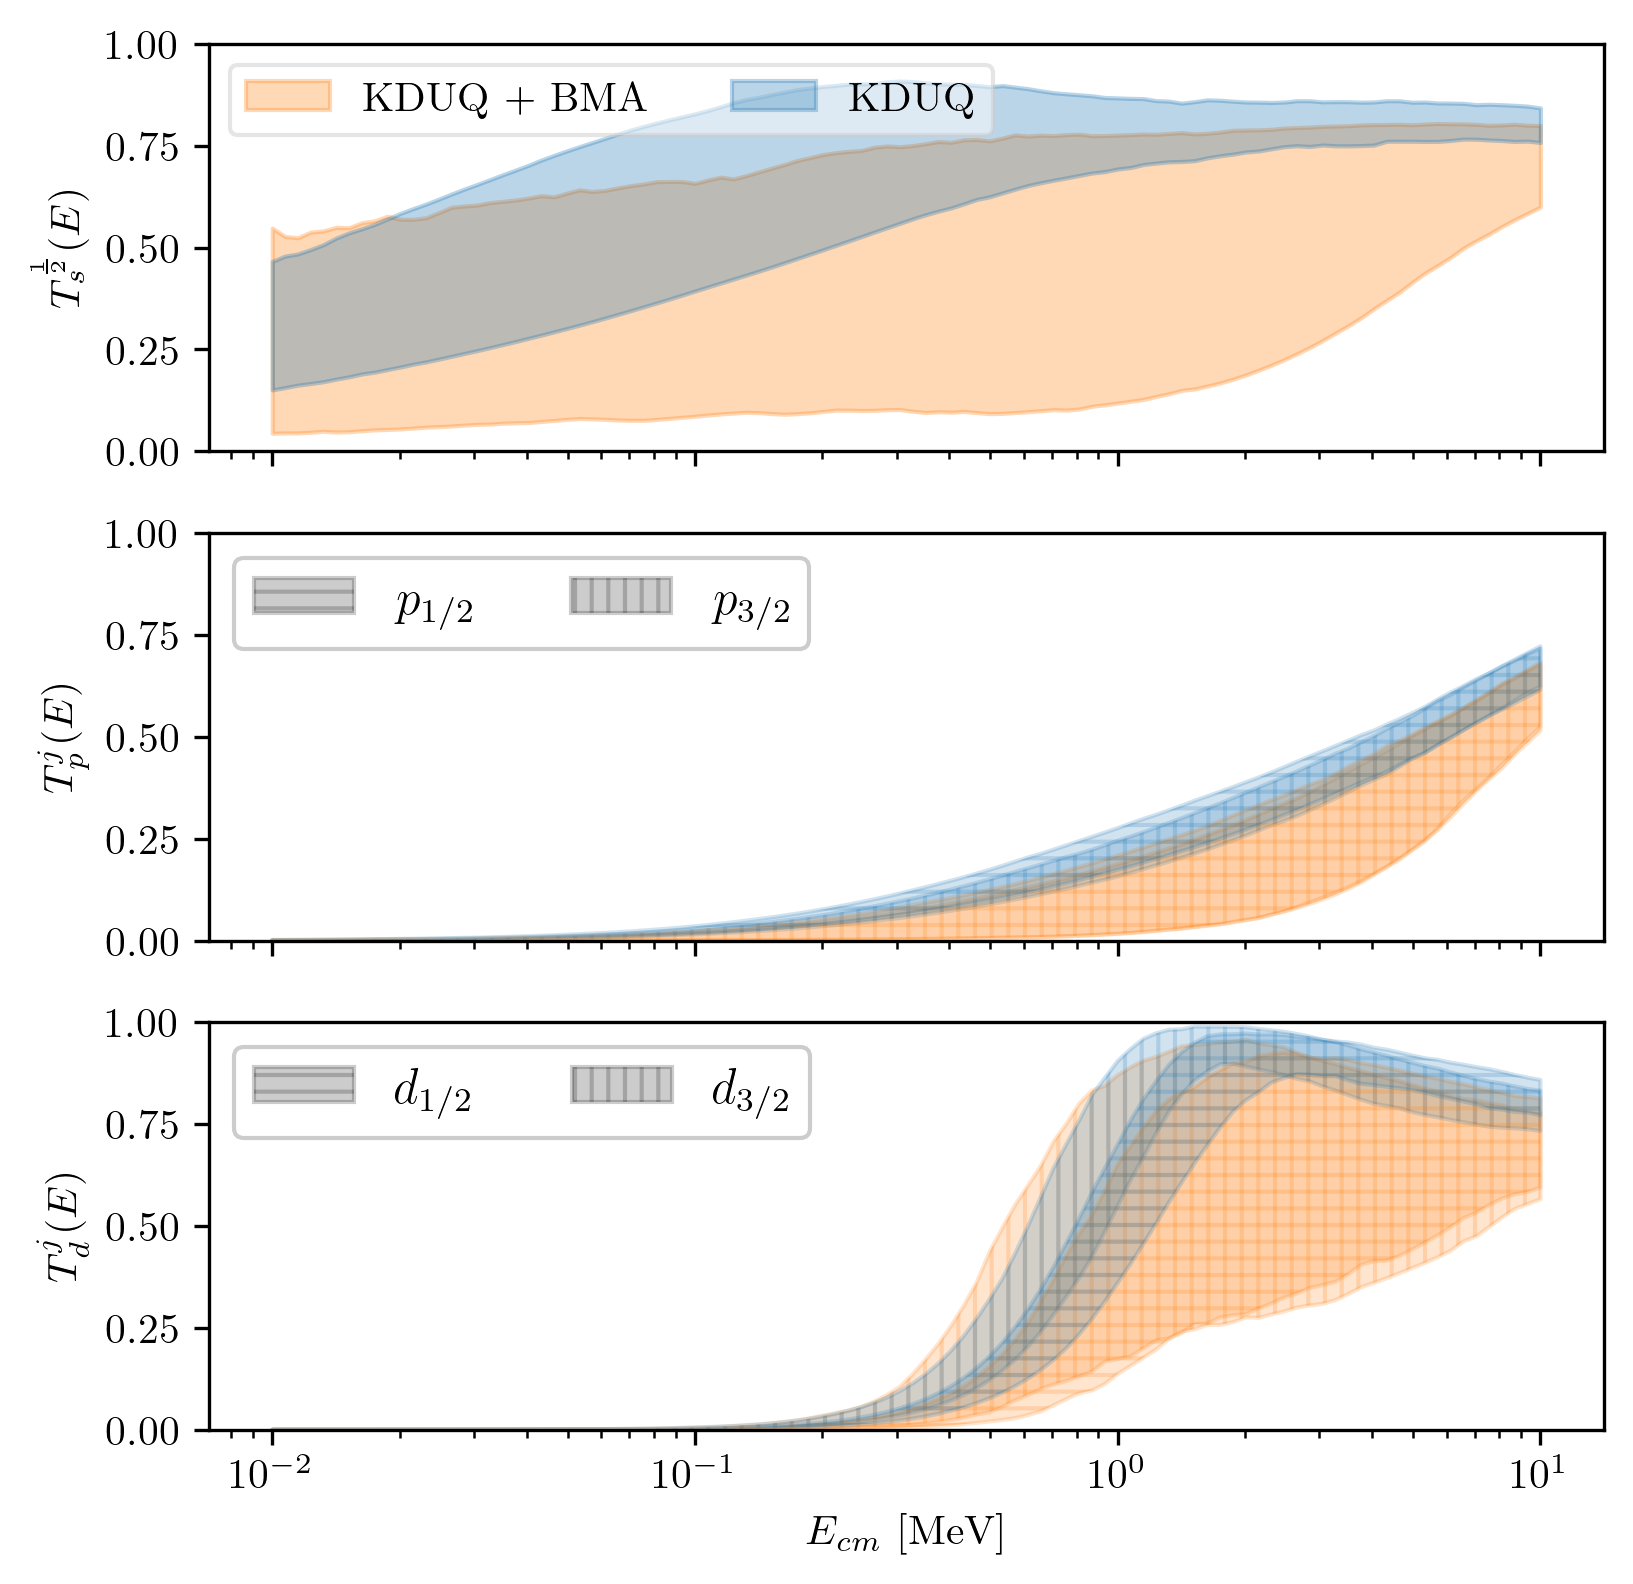

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(
    figsize=(6, 6), nrows=3, ncols=1, dpi=300, sharex=True
)

ax1.fill_between(
    com_energy_grid,
    kduq_bma_ci[0][0][0],
    kduq_bma_ci[0][0][1],
    color=bma_color,
    alpha=0.3,
    label="KDUQ + BMA",
)
ax1.fill_between(
    com_energy_grid,
    kduq_ci[0][0][0],
    kduq_ci[0][0][1],
    color=kduq_color,
    alpha=0.3,
    label="KDUQ",
)

ax2.fill_between(
    com_energy_grid,
    kduq_bma_ci[1][0][0],
    kduq_bma_ci[1][0][1],
    color=bma_color,
    alpha=0.2,
    hatch="|||",
)
ax2.fill_between(
    com_energy_grid,
    kduq_ci[1][0][0],
    kduq_ci[1][0][1],
    color=kduq_color,
    alpha=0.2,
    hatch="|||",
)
ax2.fill_between(
    com_energy_grid,
    kduq_bma_ci[1][1][0],
    kduq_bma_ci[1][1][1],
    color=bma_color,
    alpha=0.2,
    hatch="---",
)
ax2.fill_between(
    com_energy_grid,
    kduq_ci[1][1][0],
    kduq_ci[1][1][1],
    color=kduq_color,
    alpha=0.2,
    hatch="---",
)

ax3.fill_between(
    com_energy_grid,
    kduq_bma_ci[2][0][0],
    kduq_bma_ci[2][0][1],
    color=bma_color,
    alpha=0.2,
    hatch="|||",
)
ax3.fill_between(
    com_energy_grid,
    kduq_ci[2][0][0],
    kduq_ci[2][0][1],
    color=kduq_color,
    alpha=0.2,
    hatch="|||",
)
ax3.fill_between(
    com_energy_grid,
    kduq_bma_ci[2][1][0],
    kduq_bma_ci[2][1][1],
    color=bma_color,
    alpha=0.2,
    hatch="---",
)
ax3.fill_between(
    com_energy_grid,
    kduq_ci[2][1][0],
    kduq_ci[2][1][1],
    color=kduq_color,
    alpha=0.2,
    hatch="---",
)

# style legend
swave_style = [
    ax3.fill_between(
        [-1, 0],
        [-1, 0],
        [-1, 0],
        color="k",
        alpha=0.2,
    ),
]
lwave_style = [
    ax3.fill_between(
        [-1, 0],
        [-1, 0],
        [-1, 0],
        color="k",
        alpha=0.2,
        hatch="---",
    ),
    ax3.fill_between(
        [-1, 0],
        [-1, 0],
        [-1, 0],
        color="k",
        alpha=0.2,
        hatch="|||",
    ),
]


style_legend1 = ax1.legend(
    swave_style, [r"$s{1/2}$"], ncols=1, loc="lower right", fontsize=12, framealpha=1
)
style_legend2 = ax2.legend(
    lwave_style,
    [r"$p_{1/2}$", r"$p_{3/2}$"],
    ncols=2,
    loc="upper left",
    fontsize=12,
    framealpha=1,
)
style_legend3 = ax3.legend(
    lwave_style,
    [r"$d_{1/2}$", r"$d_{3/2}$"],
    ncols=2,
    loc="upper left",
    fontsize=12,
    framealpha=1,
)
ax1.legend(loc="upper left", ncols=2, framealpha=0.5)

ax1.set_ylim([0, 1])
ax2.set_ylim([0, 1])
ax3.set_ylim([0, 1])

ax1.set_ylabel(r"$T_{s}^{\frac{1}{2}}(E)$")
ax2.set_ylabel(r"$T_{p}^j(E)$")
ax3.set_ylabel(r"$T_{d}^j(E)$")

plt.xlabel(r"$E_{cm}$ [MeV]")
plt.xscale("log")